In [44]:
import pyedflib
import mne
import numpy as np

import torchvision
import torchaudio
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from IPython.display import clear_output
from tqdm.notebook import tqdm
import matplotlib.ticker as ticker
from os import listdir
import os

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [45]:
def ReadSignal(file_name): 

    f = pyedflib.EdfReader(file_name)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((20, f.getNSamples()[0])) #or n
    print(file_name, n)
    
    if n == 22:
        for i in np.arange(19):
            sigbufs[i, :] = f.readSignal(i)
        sigbufs[19, :] = f.readSignal(21)
    elif n == 23:
        for i in np.arange(19):
            sigbufs[i, :] = f.readSignal(i)
        sigbufs[19, :] = f.readSignal(20)
    elif n == 21:
        for i in np.arange(20):
            sigbufs[i, :] = f.readSignal(i)
    else:
        for i in np.arange(n):
            sigbufs[i, :] = f.readSignal(i)

    time = [1/f.samplefrequency(0) * i for i in range(len(sigbufs[0]))]

    annotations = f.readAnnotations()  

    new_annot = [(annotations[0][i], annotations[1][i], annotations[2][i])  
                 for i in range(len(annotations[0])) 
                                if (annotations[1][i] > 0) and (annotations[2][i] in ["Ð´Ð°Ð±Ð» Ñ\x81Ð¿Ð°Ð¹Ðº", "*", "?", "F7", 
                                                                                      'Ð\xa03(blockUserBlock)', "F7(blockUserBlock)", 
                                                                                      "O2(blockUserBlock)", "F7(blockUserBlock)", 
                                                                                      'Ð¡4(blockUserBlock)', 'Ñ\x8dÐ°',
                                                                                      "F7(blockUserBlock)(blockUserBlock)"])]
    f.close()
    return sigbufs, new_annot, time, f.samplefrequency(0)

In [46]:
record_names = ["NNSpecialistsData/1.edf",
                "NNSpecialistsData/-2 marked.edf",
                "NNSpecialistsData/-3 marked.edf", 
                "NNSpecialistsData/patient4.edf", 
                "NNSpecialistsData/5_marked.edf",
                "NNSpecialistsData/DDD.edf", 
                "NNSpecialistsData/SDA.edf", 
                "NNSpecialistsData/SVV.edf", 
                "NNSpecialistsData/ZSV.edf", 
                
                "MoscowSpecialistsData/P1.edf",
                "MoscowSpecialistsData/P1_2.edf",
                "MoscowSpecialistsData/P2.edf", 
                "MoscowSpecialistsData/P3.edf", 
                "MoscowSpecialistsData/P4.edf", 
                "MoscowSpecialistsData/P5.edf", 
                "MoscowSpecialistsData/P6.edf", 
                "MoscowSpecialistsData/P9.edf", 
                "MoscowSpecialistsData/P10.edf", 
                "MoscowSpecialistsData/P11.edf", 
                "MoscowSpecialistsData/P12.edf"]

records = []
annots = []
times = []
freqs = []
for file_name in record_names:

    sigbufs, new_annot, time, freq = ReadSignal("data/"+file_name)
    records.append(sigbufs)
    annots.append(new_annot)
    times.append(time)
    freqs.append(freq)
    

data/NNSpecialistsData/1.edf 20
data/NNSpecialistsData/-2 marked.edf 23
data/NNSpecialistsData/-3 marked.edf 23
data/NNSpecialistsData/patient4.edf 21
data/NNSpecialistsData/5_marked.edf 23
data/NNSpecialistsData/DDD.edf 23
data/NNSpecialistsData/SDA.edf 21
data/NNSpecialistsData/SVV.edf 21
data/NNSpecialistsData/ZSV.edf 23
data/MoscowSpecialistsData/P1.edf 20
data/MoscowSpecialistsData/P1_2.edf 20
data/MoscowSpecialistsData/P2.edf 20
data/MoscowSpecialistsData/P3.edf 20
data/MoscowSpecialistsData/P4.edf 20
data/MoscowSpecialistsData/P5.edf 20
data/MoscowSpecialistsData/P6.edf 20
data/MoscowSpecialistsData/P9.edf 20
data/MoscowSpecialistsData/P10.edf 20
data/MoscowSpecialistsData/P11.edf 20
data/MoscowSpecialistsData/P12.edf 20


In [47]:
def NormalizeAndClip(data):
    for i in tqdm(range(len(data))):
        signal = data[i]
        means = signal.mean(axis=1)[..., None]
        stds = signal.std(axis=1)[..., None]
        signal = np.clip((signal - means) / stds, a_min=-10, a_max=10)
        data[i] = signal

In [48]:
NormalizeAndClip(records)

  0%|          | 0/20 [00:00<?, ?it/s]

In [49]:
def Transform(sample_rate): # only for 199
    transform = 0
    new_freq = 0
    if sample_rate == 199:
        transform500 = torchaudio.transforms.Resample(250625, 100000)
        transform1000 = torchaudio.transforms.Resample(50125, 10000)
        
        new_freq = 80000 / 401
    else:
        transform = torchaudio.transforms.Resample(100000, 250625) 
        new_freq = 500
    for i in range(len(records)):
        if int(freqs[i]) != sample_rate:
            if int(freqs[i]) == 500:
                new_sigbufs = []
                sigbufs = records[i]
                for sig in tqdm(sigbufs):
                    new_sigbufs.append(transform500(torch.FloatTensor(sig)))
                new_sigbufs = np.array(new_sigbufs)
                records[i] = new_sigbufs
                freqs[i] = new_freq
                times[i] = [1/new_freq * j for j in range(len(new_sigbufs[0]))]   
            elif int(freqs[i]) == 1000:
                new_sigbufs = []
                sigbufs = records[i]
                for sig in tqdm(sigbufs):
                    new_sigbufs.append(transform1000(torch.FloatTensor(sig)))
                new_sigbufs = np.array(new_sigbufs)
                records[i] = new_sigbufs
                freqs[i] = new_freq
                times[i] = [1/new_freq * j for j in range(len(new_sigbufs[0]))]

In [50]:
Transform(199)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [51]:
for i in range(len(freqs)):
    freqs[i] = 80000 / 401
    times[i] = [1/freqs[i] * j for j in range(len(records[i][0]))]

In [9]:
all_labels = []

for i in range(len(records)):
    name = "data/" + record_names[i].split("/")[0] + "/Labels/" + record_names[i].split("/")[1] + "freq" + str(freqs[i])[:3]
    if "NN" in record_names[i]:
        all_labels.append(np.load(name + ".npy"))
    elif "Moscow" in record_names[i]:
        all_labels.append(np.load(name + ".npy"))

# SNEO

In [10]:
def SNEO(signal, window_len = 50):
    padded_signal = np.zeros(len(signal) + 2)
    padded_signal[1:-1] = signal
    psi = signal ** 2 - padded_signal[:-2] * padded_signal[2:]
    
    trian_window = 1 - np.abs(2 * np.arange(window_len) / (window_len - 1) - 1 )
    return np.convolve(psi, trian_window, "same")

### Saving Sneo

In [19]:
def CalculateRecordSNEO(record):
    sneo_signals = []
    for lead in record[:-1]:
        sneo_signals.append(SNEO(lead))
    sneo_signals = np.array(sneo_signals)
    sneo_signals = np.concatenate((sneo_signals, np.zeros((1, record.shape[1]))), axis=0)
    assert sneo_signals.shape == record.shape
    return sneo_signals

In [21]:
for i in tqdm(range(len(records))):
    name = "data/" + record_names[i].split("/")[0] + "/SNEO/" + record_names[i].split("/")[1] + "freq" + str(freqs[i])[:3]
    if "NN" in record_names[i] and not os.path.exists(name + ".npy"):
        sneo = CalculateRecordSNEO(records[i])
        np.save(name, sneo)
    elif "Moscow" in record_names[i] and not os.path.exists(name + ".npy"):
        sneo = CalculateRecordSNEO(records[i])
        np.save(name, sneo)

  0%|          | 0/20 [00:00<?, ?it/s]

### Showing sneo

shapes of the record and sneo are equal

In [23]:
i=4
sneo_signals = np.load("data/" + record_names[i].split("/")[0] + "/SNEO/" + record_names[i].split("/")[1] + "freq" + str(freqs[i])[:3] + ".npy")

In [24]:
train_time_start = annots[i][0][0]
train_time_end = annots[i][-1][0]
train_idx_start = (np.array(times[i]) < train_time_start).argmin()
train_idx_fin = (np.array(times[i])< train_time_end).argmin()

sneo_signals = sneo_signals[:, train_idx_start:train_idx_fin]

In [25]:
test_labels = all_labels[i][train_idx_start:train_idx_fin]

In [26]:
count_zero = 0
silence = []
epi = []
in_epi_flag = False
for i in range(len(sneo_signals[0])-100):
    if test_labels[i] == 0:
        in_epi_flag = False
        count_zero += 1
    if count_zero == 100:
        count_zero = 0
        silence.append(sneo_signals[:, i-100:i].sum(axis=0))
    
    if test_labels[i] == 1 and not in_epi_flag:
        count_zero = 0
        in_epi_flag = True
        epi.append(sneo_signals[:, i-30:i+70].sum(axis=0))

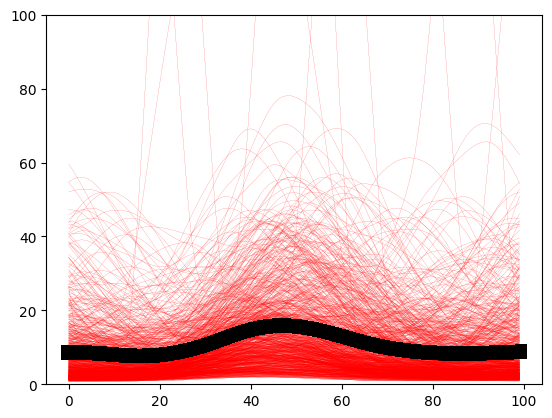

In [27]:
mean_epi = np.array(epi[1:]).mean(axis=0)
for epi_sample in epi:
    plt.plot(epi_sample, c="red", linewidth=0.1)
    plt.plot(mean_epi, c="black", linewidth = 10)
    plt.ylim(0, 100)

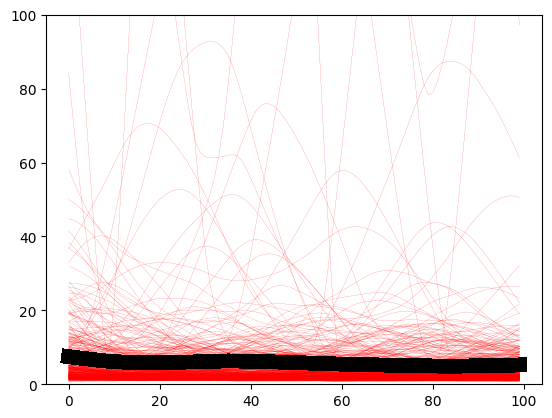

In [28]:
mean_silence = np.array(silence).mean(axis=0)
for silence_sample in silence:
    plt.plot(silence_sample, c="red", linewidth=0.1)
    plt.plot(mean_silence, c="black", linewidth = 10)
    plt.ylim(0, 100)

In [15]:
test_record = records[2]

In [16]:
sneo_signals = []
for lead in test_record[:-1]:
    sneo_signals.append(SNEO(lead))
sneo_signals = np.array(sneo_signals)

In [116]:
train_time_start = annots[2][0][0]
train_time_end = annots[2][-1][0]
train_idx_start = (np.array(times[2]) < train_time_start).argmin()
train_idx_fin = (np.array(times[2])< train_time_end).argmin()

sneo_signals = sneo_signals[:, train_idx_start:train_idx_fin]

In [117]:
test_labels = all_labels[2][train_idx_start:train_idx_fin]

In [118]:
count_zero = 0
silence = []
epi = []
in_epi_flag = False
for i in range(len(sneo_signals[0])-100):
    if test_labels[i] == 0:
        in_epi_flag = False
        count_zero += 1
    if count_zero == 100:
        count_zero = 0
        silence.append(sneo_signals[:, i-100:i].sum(axis=0))
    
    if test_labels[i] == 1 and not in_epi_flag:
        count_zero = 0
        in_epi_flag = True
        epi.append(sneo_signals[:, i-30:i+70].sum(axis=0))

In [119]:
len(silence)

510

In [120]:
len(epi)

919

In [121]:
for sample in epi:
    if len(sample) != 100:
        print(len(sample))

0


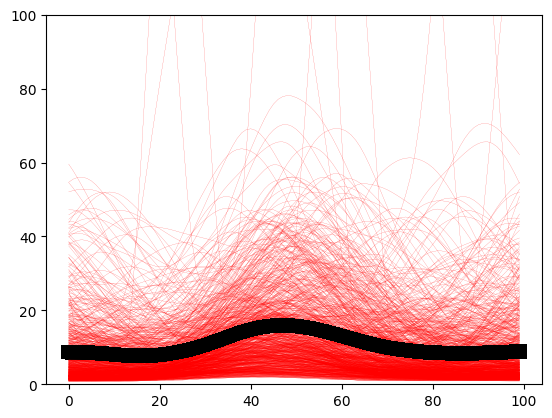

In [122]:
mean_epi = np.array(epi[1:]).mean(axis=0)
for epi_sample in epi:
    plt.plot(epi_sample, c="red", linewidth=0.1)
    plt.plot(mean_epi, c="black", linewidth = 10)
    plt.ylim(0, 100)

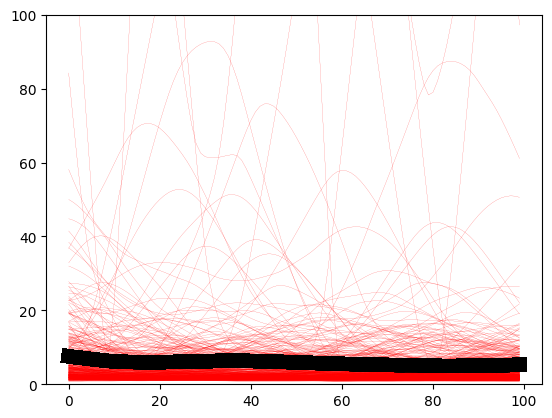

In [123]:
mean_silence = np.array(silence).mean(axis=0)
for silence_sample in silence:
    plt.plot(silence_sample, c="red", linewidth=0.1)
    plt.plot(mean_silence, c="black", linewidth = 10)
    plt.ylim(0, 100)

# Mc

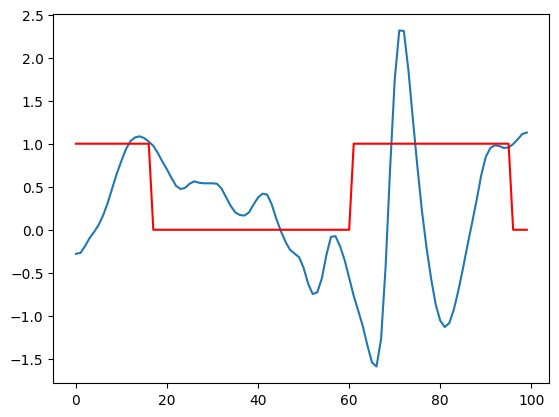

In [85]:
for i in [2]:
    plt.plot(test_record[i, train_idx_start:train_idx_start+1000][300:400])
plt.plot(test_labels[:1000][300:400], c="Red")

hs = 2.2

In [52]:
hs = 2.2
ts = 40
g = hs * np.sin(np.pi * np.arange(0, ts) / ts)

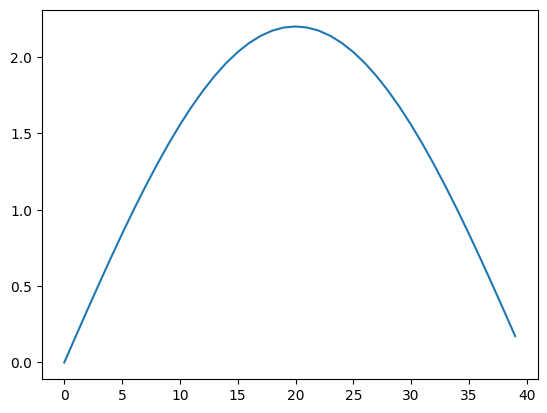

In [92]:
plt.plot(g)

In [53]:
def Corossion(signal, elem):
    m = len(elem)
    n = len(signal)
    padded_signal = np.zeros(n + m - 1)
    cor = np.zeros_like(signal)
    for i in range(n):
        cor[i] = np.min(padded_signal[i:i+m] - elem)
    return cor

def Expansion(signal, elem):
    m = len(elem)
    n = len(signal)
    padded_signal = np.zeros(n + m - 1)
    cor = np.zeros_like(signal)
    for i in range(n):
        cor[i] = np.max(padded_signal[i:i+m] - elem)
    return cor

def Opening(signal, elem):
    return Expansion(Corossion(signal, elem), elem)
    
def Closing(signal, elem):
    return Corossion(Expansion(signal, elem), elem)

def OC(signal, elem):
    return Closing(Opening(signal, elem), elem)
    
def CO(signal, elem):
    return Opening(Closing(signal, elem), elem)

def MC(signal, elem):
    return signal - 0.5 * (OC(signal, elem) + CO(signal, elem))

### Saving mc

In [54]:
def CalculateRecordMC(record):
    mc_signals = []
    for lead in record[:-1]:
        mc_signals.append(MC(lead, g))
    mc_signals = np.array(mc_signals)
    mc_signals = np.concatenate((mc_signals, np.zeros((1, record.shape[1]))), axis=0)
    assert mc_signals.shape == record.shape
    return mc_signals

In [58]:
for i in tqdm(range(len(records))):
    name = "data/" + record_names[i].split("/")[0] + "/MC/" + record_names[i].split("/")[1] + "freq" + str(freqs[i])[:3]
    if "NN" in record_names[i]:# and not os.path.exists(name + ".npy"):
        mc = CalculateRecordMC(records[i])
        np.save(name, mc)
    elif "Moscow" in record_names[i] and not os.path.exists(name + ".npy"):
        mc = CalculateRecordMC(records[i])
        np.save(name, mc)

  0%|          | 0/20 [00:00<?, ?it/s]

In [95]:
mc_signals = []
for lead in tqdm(test_record[:-1]):
    mc_signals.append(MC(lead, g))
mc_signals = np.array(mc_signals)

100%|█████████████████████████████████████████████████████████████████████| 19/19 [07:20<00:00, 23.16s/it]


In [96]:
mc_signals = mc_signals[:, train_idx_start:train_idx_fin]

In [102]:
count_zero = 0
silence = []
epi = []
in_epi_flag = False
for i in range(len(mc_signals[0])-100):
    if test_labels[i] == 0:
        in_epi_flag = False
        count_zero += 1
    if count_zero == 100:
        count_zero = 0
        silence.append(mc_signals[2, i-100:i])
    
    if test_labels[i] == 1 and not in_epi_flag:
        count_zero = 0
        in_epi_flag = True
        epi.append(mc_signals[2, i-30:i+70])

In [103]:
len(silence)

510

In [104]:
len(epi)

919

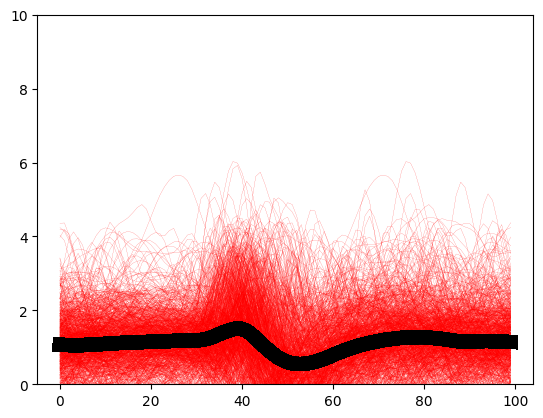

In [111]:
mean_epi = np.array(epi[1:]).mean(axis=0)
for epi_sample in epi:
    plt.plot(epi_sample, c="red", linewidth = 0.1)
    plt.plot(mean_epi, linewidth = 10, c="black")
    plt.ylim(0, 10)

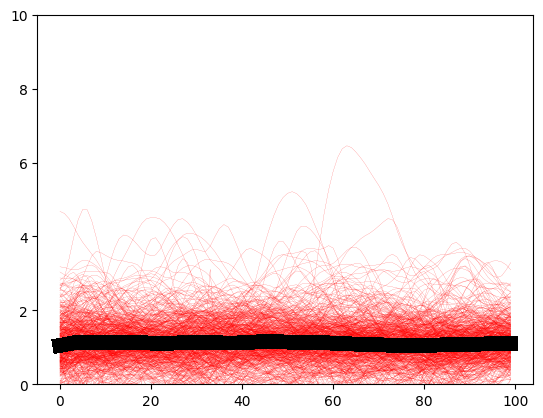

In [112]:
mean_silence = np.array(silence).mean(axis=0)
for silence_sample in silence:
    plt.plot(silence_sample, c="red", linewidth = 0.1)
    plt.plot(mean_silence, linewidth = 10, c="black")
    plt.ylim(0, 10)

### NetWork

In [39]:
class conbr_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, stride, dilation):
        super(conbr_block, self).__init__()

        self.conv1 = nn.Conv1d(in_layer, out_layer, kernel_size=kernel_size, stride=stride, dilation = dilation, padding = 3, bias=True)
        self.bn = nn.BatchNorm1d(out_layer)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn(x)
        out = self.relu(x)
        
        return out       

class se_block(nn.Module):
    def __init__(self,in_layer, out_layer):
        super(se_block, self).__init__()
        
        self.conv1 = nn.Conv1d(in_layer, out_layer//8, kernel_size=1, padding=0)
        self.conv2 = nn.Conv1d(out_layer//8, in_layer, kernel_size=1, padding=0)
        self.fc = nn.Linear(1,out_layer//8)
        self.fc2 = nn.Linear(out_layer//8,out_layer)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):

        x_se = nn.functional.adaptive_avg_pool1d(x,1)
        x_se = self.conv1(x_se)
        x_se = self.relu(x_se)
        x_se = self.conv2(x_se)
        x_se = self.sigmoid(x_se)
        
        x_out = torch.add(x, x_se)
        return x_out

class re_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, dilation):
        super(re_block, self).__init__()
        
        self.cbr1 = conbr_block(in_layer,out_layer, kernel_size, 1, dilation)
        self.cbr2 = conbr_block(out_layer,out_layer, kernel_size, 1, dilation)
        self.seblock = se_block(out_layer, out_layer)
    
    def forward(self,x):

        x_re = self.cbr1(x)
        x_re = self.cbr2(x_re)
        x_re = self.seblock(x_re)
        x_out = torch.add(x, x_re)
        return x_out          

class UNET_1D(nn.Module):
    def __init__(self ,input_dim,layer_n,kernel_size,depth, n_features=1):
        super(UNET_1D, self).__init__()
        self.input_dim = input_dim
        self.layer_n = layer_n
        self.kernel_size = kernel_size
        self.depth = depth
        
        self.AvgPool1D1 = nn.AvgPool1d(input_dim, stride=5, padding=8)
        self.AvgPool1D2 = nn.AvgPool1d(input_dim, stride=25, padding=8)
        #self.AvgPool1D3 = nn.AvgPool1d(input_dim, stride=125, padding=8)
        
        self.layer1 = self.down_layer(self.input_dim, self.layer_n, self.kernel_size,1, 2)
        self.layer1_sneo = self.down_layer(self.input_dim, self.layer_n, self.kernel_size,1, 2)
        self.layer1_mc = self.down_layer(self.input_dim, self.layer_n, self.kernel_size,1, 2)
        
        self.layer2 = self.down_layer(self.layer_n, int(self.layer_n*2), self.kernel_size,5, 2)
        self.layer3 = self.down_layer(int(self.layer_n*2)+n_features*int(self.input_dim), int(self.layer_n*3), self.kernel_size,5, 2)
        self.layer4 = self.down_layer(int(self.layer_n*3)+n_features*int(self.input_dim), int(self.layer_n*4), self.kernel_size,5, 2)
        #self.layer5 = self.down_layer(int(self.layer_n*4)+n_features*int(self.input_dim), int(self.layer_n*5), self.kernel_size,4, 2)

        self.cbr_up1 = conbr_block(int(self.layer_n*7), int(self.layer_n*3), self.kernel_size, 1, 1)
        self.cbr_up2 = conbr_block(int(self.layer_n*5), int(self.layer_n*2), self.kernel_size, 1, 1)
        self.cbr_up3 = conbr_block(int(self.layer_n*3), self.layer_n, self.kernel_size, 1, 1)
        self.upsample = nn.Upsample(scale_factor=5, mode='nearest')
        self.upsample1 = nn.Upsample(scale_factor=5, mode='nearest') #for 4000 it is 5 and for 100 is 4
        
        self.outcov = nn.Conv1d(self.layer_n, 2, kernel_size=self.kernel_size, stride=1,padding = 3)
    
        
    def down_layer(self, input_layer, out_layer, kernel, stride, depth):
        block = []
        block.append(conbr_block(input_layer, out_layer, kernel, stride, 1))
        for i in range(depth):
            block.append(re_block(out_layer,out_layer,kernel,1))
        return nn.Sequential(*block)
    
    def forward(self, x):
        
        #print("x", x.size())
        pool_x1 = self.AvgPool1D1(x)
        pool_x2 = self.AvgPool1D2(x)
        pool_x3 = self.AvgPool1D3(x)
        #############Encoder#####################
        
        out_0 = self.layer1(x)
        out_1 = self.layer2(out_0)
        
        x = torch.cat([out_1,pool_x1],1)

        out_2 = self.layer3(x)
        
        x = torch.cat([out_2,pool_x2],1)
        x = self.layer4(x)
        
        
        #############Decoder####################
        
        up = self.upsample1(x)
        
        up = torch.cat([up,out_2],1)
        
        up = self.cbr_up1(up)
        
        up = self.upsample(up)
        
        up = torch.cat([up,out_1],1)
        
        up = self.cbr_up2(up)
        
        up = self.upsample(up)
        
        up = torch.cat([up,out_0],1)
        
        
        up = self.cbr_up3(up)
        
        out = self.outcov(up)

        
        return out
            
    def forward(self, x, sneo=None, mc=None):
        
        if sneo is not None:
            pool_x1 = self.AvgPool1D1(x)
            pool_sneo1 = self.AvgPool1D1(sneo)
            pool_mc1 = self.AvgPool1D1(mc)


            pool_x2 = self.AvgPool1D2(x)
            pool_sneo2 = self.AvgPool1D2(sneo)
            pool_mc2 = self.AvgPool1D2(mc)


            #############Encoder#####################

            out_0 = self.layer1(x)
            out_0_sneo = self.layer1_sneo(sneo)
            out_0_mc = self.layer1_mc(mc)

            out_1 = self.layer2(out_0 + out_0_sneo + out_0_mc)        


            x = torch.cat([out_1,pool_x1, pool_sneo1, pool_mc1],1)

            out_2 = self.layer3(x)

            x = torch.cat([out_2,pool_x2, pool_sneo2, pool_mc2],1)
            x = self.layer4(x)


            #############Decoder####################

            up = self.upsample1(x)

            up = torch.cat([up,out_2],1)

            up = self.cbr_up1(up)

            up = self.upsample(up)

            up = torch.cat([up,out_1],1)

            up = self.cbr_up2(up)


            up = self.upsample(up)

            up = torch.cat([up,out_0+out_0_sneo+out_0_mc],1)

            up = self.cbr_up3(up)

            out = self.outcov(up)

            return out
        else:
            pool_x1 = self.AvgPool1D1(x)
            pool_x2 = self.AvgPool1D2(x)
            
            #############Encoder#####################

            out_0 = self.layer1(x)
            out_1 = self.layer2(out_0)

            x = torch.cat([out_1,pool_x1],1)

            out_2 = self.layer3(x)

            x = torch.cat([out_2,pool_x2],1)
            x = self.layer4(x)


            #############Decoder####################

            up = self.upsample1(x)

            up = torch.cat([up,out_2],1)

            up = self.cbr_up1(up)

            up = self.upsample(up)

            up = torch.cat([up,out_1],1)

            up = self.cbr_up2(up)

            up = self.upsample(up)

            up = torch.cat([up,out_0],1)


            up = self.cbr_up3(up)

            out = self.outcov(up)


            return out 

In [40]:
### check
model_check = UNET_1D(20,128,7,3,3)
out = model_check(torch.zeros((8, 20, 4000)), torch.zeros((8, 20, 4000)), torch.zeros((8, 20, 4000)))

In [41]:
out.shape

torch.Size([8, 2, 4000])

In [42]:
model_check = UNET_1D(20,128,7,3,1)
out = model_check(torch.zeros((8, 20, 4000)))

In [43]:
out.shape

torch.Size([8, 2, 4000])